### Get Feedback on Your LLM Chatbot - and put it to use

Ensure all steps in [00_setup.ipynb](./00_setup.ipynb) have been completed.  

In this notebook:
- Analyze Production model inputs and outputs with automatic Data Collection in Azure
  - User interaction analysis
  - Metrics from testing/evaluation
- How to use an LLM to summarize and categorize human feedback

### Azure Model Data Collector

Because we have enabled the Data Collector in our [deployment](./src/deployment_scripts/deployment.yml) yml file. Both input and output data will automatically be sent to Storage for analysis. You can view the data by navigating to your AML Workspace --> Data.  
Note: Data will only appear _after_ the deployment has been hit.  
  
  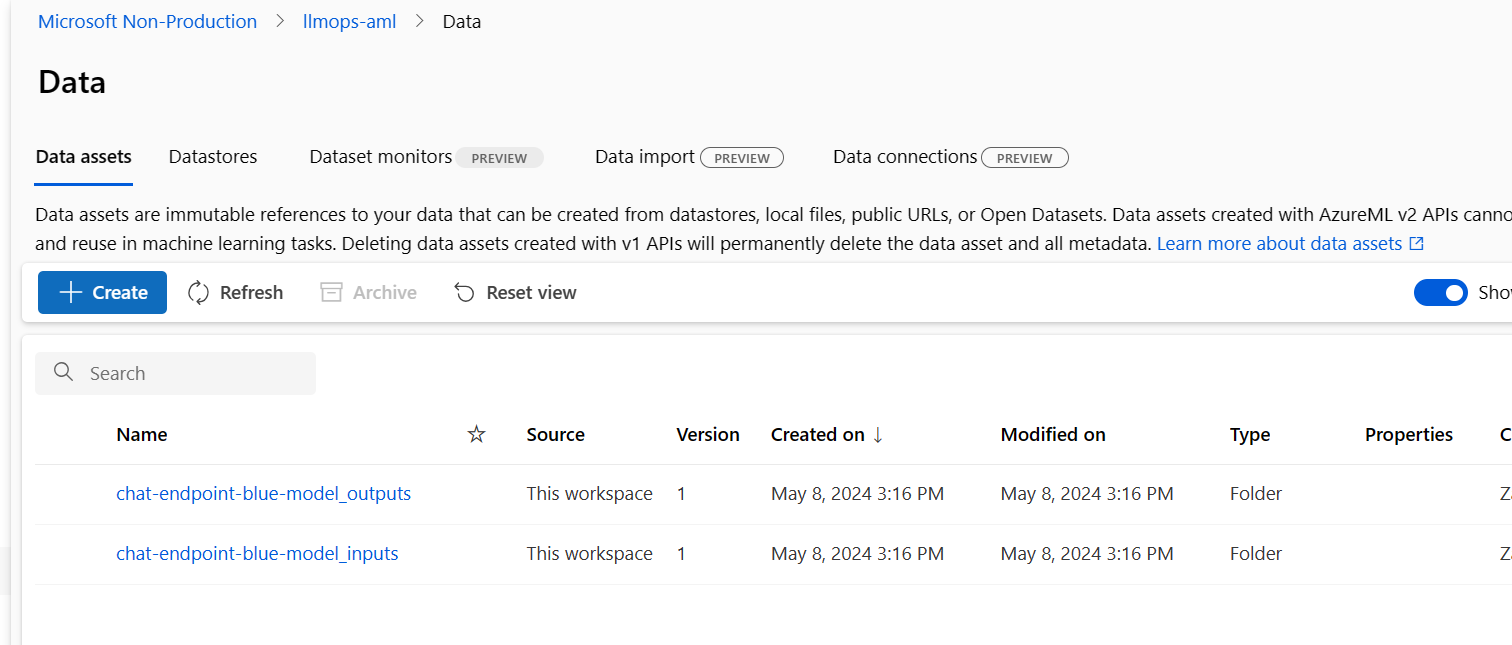

### Analyze Evaluation Metrics on Production Responses

In [ ]:
# import necessary libraries
from promptflow.azure import PFClient
from promptflow.entities import Run
from azure.identity import DefaultAzureCredential
from openai import AzureOpenAI
import os
import mltable
import json
import pandas as pd
from azure.ai.ml import MLClient
from dotenv import load_dotenv, find_dotenv

In [ ]:
load_dotenv(find_dotenv(), override=True)

In [ ]:
# Get handle to workspace

ml_client = MLClient(credential=DefaultAzureCredential(),
                     subscription_id=os.getenv('SUBSCRIPTION_ID'),
                     resource_group_name=os.getenv('RESOURCE_GROUP_NAME'),
                     workspace_name=os.getenv('WORKSPACE_NAME')
                    )

pf = PFClient(credential=DefaultAzureCredential(),
              subscription_id=os.getenv('SUBSCRIPTION_ID'),
              resource_group_name=os.getenv('RESOURCE_GROUP_NAME'),
              workspace_name=os.getenv('WORKSPACE_NAME')
            )

In [ ]:
# Get datasets
output_data_asset = ml_client.data.get("chat-endpoint-blue-model_outputs", version="1")
output_tbl = mltable.from_json_lines_files(paths=[{"folder": output_data_asset.path}])
outputs_df  = output_tbl.to_pandas_dataframe()

input_data_asset = ml_client.data.get("chat-endpoint-blue-model_inputs", version="1")
input_tbl = mltable.from_json_lines_files(paths=[{"folder": input_data_asset.path}])
inputs_df  = input_tbl.to_pandas_dataframe()

In [ ]:
# Join on xrequestid
joined_df = pd.merge(inputs_df[['data','xrequestid']], outputs_df[['data','xrequestid']], on='xrequestid', how='inner')
joined_df = joined_df.rename(columns={"data_x": "input_data", "data_y": "output_data"})

# Do some data formatting
joined_df["input_data"] = joined_df["input_data"].apply(lambda x: x[0])
joined_df["output_data"] = joined_df["output_data"].apply(lambda x: x[0])

# filter out detected attacks
joined_df = joined_df[joined_df["output_data"].apply(lambda x: x['attack_detected'] == False)]

joined_df["input"] = pd.json_normalize(joined_df["input_data"])["input"]
joined_df["context"] = pd.json_normalize(joined_df["output_data"])["context"]
joined_df["answer"] = pd.json_normalize(joined_df["output_data"])["answer"]
joined_df.drop(columns=["input_data", "output_data"], inplace=True)


display(joined_df.head())

# Save df to local
joined_df.to_json('data/sample_joined_production_data.jsonl', orient='records', lines=True)

In [ ]:
# Run evaluation flow on output data
eval_flow = "./src/evaluation/eval_flow" # set flow directory

# Define remote compute instance (serverless)
resources = {"instance_type": "Standard_D2"}
data = './data/sample_joined_production_data.jsonl'


##### Run eval flow  #########
eval_run = Run(
    display_name="Eval RAG Wiki - PROD DATA - Run",
    flow=eval_flow,
    data=data,
    resources=resources,
    column_mapping={  # map the url field from the data to the url input of the flow
    "question": "${data.input}",
    "answer": "${data.answer}",
    "context": "${data.context}"
    }
)

eval_run_job = pf.runs.create_or_update(
    run=eval_run,
)

pf.runs.stream(eval_run_job)

In [ ]:
# View all scores
display(pf.get_details(eval_run))

# View aggregate scores
display(json.dumps(pf.get_metrics(eval_run)))

### Summarize and Categorize User Feedback

This next section demonstrates how an LLM can effectively draw insights from user feedback. Imagine a user survey with hundreds of responses [(sample dataset)](./data/sample_user_feedback.csv), let's use GPT to break down user feedback into areas of improvement / development focus

In [ ]:
# Prepare dataset
feedback_df = pd.read_csv("./data/sample_user_feedback.csv")
feedback_str = ';'.join(feedback_df['user_feedback'].tolist())
print(feedback_str)

In [ ]:
client = AzureOpenAI(
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"), 
  api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
  api_version="2024-02-01"
)

def summarize_top_feedback(msg):
    summary_sys_message = "You are a helpful AI assistant and an expert summarizer. Your job is to summarize user feedback. Given a list of user feedback, delimited by a ';' . You will provide a 5 setance or less summary of Positive feedback followed by a 5 sentance or less summary of Negative feedback. ## Example output Positive: Users were happy with the level of detail and the user interface design. Negative: Users think that the response time is too slow and could be improved. Also, questions pertrianin to history were not adequately answered."
    response = client.chat.completions.create(
        model=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
        messages=[
            {"role": "system", "content": summary_sys_message},
            {"role": "user", "content": msg},
        ]
    )
    return response.choices[0].message.content


def list_feedback_categories(msg):
    category_sys_message = "You are a helpful AI assistant and an expert summarizer. Your job is to summarize user feedback. Given a list of user feedback, delimited by a ';'. You will summarize the list into two lists. One list of Positive categories and one list of Negative cateogries. Please include as many items as needed in each Category List. ## Example output Positive: UI Design, Detail, Technical ability Negative: Slowness, Robotic Sounding"
    response = client.chat.completions.create(
        model=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
        messages=[
            {"role": "system", "content": category_sys_message},
            {"role": "user", "content": msg},
        ]
    )
    return response.choices[0].message.content



In [ ]:
summary = summarize_top_feedback(feedback_str)
print(summary)

In [ ]:
cateogories = list_feedback_categories(feedback_str)
print(cateogories)